### First read data from the disk

In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import copy
%matplotlib inline

def load_training_data(directory):
    df_raw = pd.read_csv('./'+directory+'/driving_log.csv')
    df_raw.columns = ['center','left','right','steering','throttle','brake','speed']
    directory_series = np.empty( len(df_raw), dtype=object)
    directory_series[:] = directory
    df_raw['directory'] = pd.Series( directory_series, index=df_raw.index)
    return df_raw

def plot_hist(dataframe, bins = 20):  
    steering_cmds = dataframe.as_matrix(columns=['steering'])
    steering_data = steering_cmds[:,0]
    n, bins, patches = plt.hist(steering_data, bins, facecolor='green', alpha=0.75)
    

3405
3708
1911
2254
11278


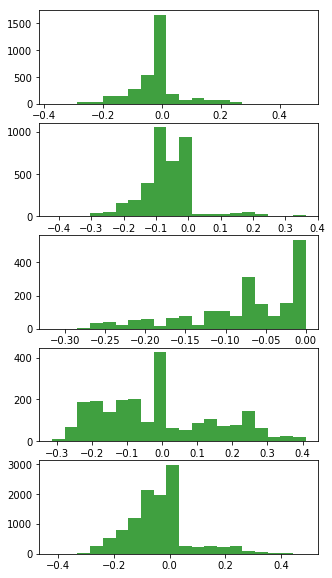

In [2]:
directory1 = 'training_data1'
df_straight = load_training_data(directory1)
directory2 = 'training_data_turn'
df_turn = load_training_data(directory2)
directory3 = 'training_data_turn2'
df_turn2 = load_training_data(directory3)
directory4 = 'training_data_3'
df_train4 = load_training_data(directory4)


# preprocessing throw all the data where speed is smaller than 2

df_turn_preprocess = df_turn[ df_turn.speed > 5 ] 
df_straight_preprocess = df_straight[ ((df_straight.speed > 20.0) & (df_straight.speed < 30.0))] 
df_turn2_preprocess = df_turn2[ df_turn2.speed > 5 ] 
df_train4_preprocess =  df_train4[ df_train4.speed > 3] 

#df[ ((df.steering > -0.3) & (df.steering < -0.25) )]

frames = [df_turn_preprocess, df_straight_preprocess, df_turn2_preprocess, df_train4_preprocess]
df = pd.concat(frames, ignore_index=True)

print (len(df_straight_preprocess))
print (len(df_turn_preprocess))
print (len(df_turn2_preprocess))
print (len(df_train4_preprocess))

print (len(df))
plt.figure(figsize=(5,10))
plt.subplot(5, 1, 1)
plot_hist(df_straight_preprocess)
plt.subplot(5, 1, 2)
plot_hist(df_turn_preprocess)
plt.subplot(5, 1, 3)
plot_hist(df_turn2_preprocess)
plt.subplot(5, 1, 4)
plot_hist(df_train4_preprocess)
plt.subplot(5, 1, 5)
plot_hist(df)


In [3]:
# spllit train validation 
# split df_merge into training and validation set
msk = np.random.rand(len(df)) < 0.8
train_samples = df[msk]
validation_samples = df[~msk]
print ('training n %d', len(train_samples))
print ('validation n %d', len(validation_samples))


training n %d 9095
validation n %d 2183


In [4]:
def compute_offset(steering_angle):
    max_offset = 0.3
    min_offset = 0.1
    param_a = (max_offset -  min_offset) / (0.4 * 0.4)
    offset = param_a * steering_angle * steering_angle + min_offset
    return offset

In [5]:
import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        #shuffle(samples)
        samples.apply(np.random.permutation)
        #print (samples.speed[0:3])
        for offset in range(0, num_samples, batch_size):
            df_batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for row_index, series in df_batch_samples.iterrows():
                name = './'+ series.directory+'/IMG/'+series.center.split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(series.steering)
                images.append(center_image)
                angles.append(center_angle)
                
                # flip image 
                center_image_flipped = np.fliplr(center_image)
                center_image_flipped_cmd = -center_angle
                images.append(center_image_flipped)
                angles.append(center_image_flipped_cmd)                
            
                left_name = './'+ series.directory+'/IMG/'+series.left.split('/')[-1]
                left_image = cv2.imread(left_name)
                left_angle = float(series.steering) + compute_offset(float(series.steering))
                images.append(left_image)
                angles.append(left_angle)

                # flip left image 
                left_image_flipped = np.fliplr(left_image)
                left_image_flipped_cmd = -left_angle
                images.append(left_image_flipped)
                angles.append(left_image_flipped_cmd)                

            
                right_name = './'+ series.directory+'/IMG/'+series.right.split('/')[-1]
                right_image = cv2.imread(right_name)
                right_angle = float(series.steering) - compute_offset(float(series.steering))
                images.append(right_image)
                angles.append(right_angle)
                
                right_image_flipped = np.fliplr(right_image)
                right_image_flipped_cmd = -right_angle
                images.append(right_image_flipped)
                angles.append(right_image_flipped_cmd)
           
            
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
           
            yield sklearn.utils.shuffle(X_train, y_train)
            #return sklearn.utils.shuffle(X_train, y_train)


            
# compile and train the model using the generator function

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)



### Visualize training data

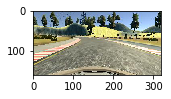

In [6]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

(X_training, y_train) =  next(train_generator)

random_image = random.randint(0 , X_training.shape[0])   
#plt.figure( figsize =(100,100))
plt.subplot(3, 1, 1)
plt.imshow( cv2.cvtColor(X_training[random_image], cv2.COLOR_BGR2RGB) )
#plt.subplot(3, 1, 2)
#plt.imshow( cv2.cvtColor(X_training_left[random_image], cv2.COLOR_BGR2RGB) )
#plt.subplot(3, 1, 3)
#plt.imshow( cv2.cvtColor(X_training_right[random_image], cv2.COLOR_BGR2RGB) )


In [7]:
## use left and right image to train on non zero datas 
df.loc[lambda df: df.steering != 0, :]



,center,left,right,steering,throttle,brake,speed,directory
29,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.064429,0.006559,0.0,7.673576,training_data_turn
30,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.083719,0.000000,0.0,7.610806,training_data_turn
31,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.141590,0.000000,0.0,7.547617,training_data_turn
32,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.189815,0.000000,0.0,7.480503,training_data_turn
33,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.209105,0.000000,0.0,7.418579,training_data_turn
34,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.160880,0.000000,0.0,7.359037,training_data_turn
35,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.093364,0.000000,0.0,7.301185,training_data_turn
36,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.103009,0.000000,0.0,7.246170,training_data_turn
37,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.093364,0.000000,0.0,7.188112,training_data_turn
38,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,-0.093364,0.006559,0.0,7.121960,training_data_turn


### Data augmentation

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense , Lambda, MaxPooling2D, Dropout,Cropping2D

i_shape = (160, 320,3)

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=i_shape ))
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))

# conv_net
model.add(Conv2D( 6, 5, 5, activation='relu' ))
model.add(Conv2D( 6, 5, 5,  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
########################################################################
# conv_net
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#########################################################################
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
#model.fit(X_training, y_train, validation_split = 0.2, shuffle=True)
model.fit_generator(train_generator, samples_per_epoch= 3*len(train_samples), validation_data=validation_generator, nb_val_samples=3*len(validation_samples), nb_epoch=5)
model.save('first_model.h5')




Using TensorFlow backend.


Epoch 1/5


KeyboardInterrupt: 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense , Lambda, MaxPooling2D, Dropout,Cropping2D

i_shape = (160, 320,3)

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=i_shape ))
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))

# conv_net
model.add(Conv2D( 24, 5, 5, subsample=(2,2), activation='relu' ))
model.add(Conv2D( 36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Conv2D( 48, 5, 5, subsample=(2,2), activation='relu'))
# conv_net
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
#model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
#model.fit(X_training, y_train, validation_split = 0.2, shuffle=True)
model.fit_generator(train_generator, samples_per_epoch= 6 * len(train_samples), validation_data=validation_generator, nb_val_samples=6 * len(validation_samples), nb_epoch=5)
model.save('nvidia_model.h5')




Epoch 1/5
54570/54570 [==============================] - 1415s - loss: 0.0153 - val_loss: 0.0111

### Fine tune 

In [ ]:
from keras.models import load_model

model = load_model('first_model.h5')
model.fit_generator(train_generator, samples_per_epoch= 3*len(train_samples), validation_data=validation_generator, nb_val_samples=3*len(validation_samples), nb_epoch=5)
model.save('first_model_fine_tune.h5')

